In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [2]:
df = pd.read_csv("data/clean_data.csv", parse_dates=["time"])
df = df.sort_values("time")

In [3]:
df.head()

,time,temperature_2m,relative_humidity_2m,rain,wind_direction_10m,wind_speed_10m,aqi_pm25,hour,month,day_of_week,is_weekend,is_raining
0,2022-08-05 07:00:00,26.6,90,0.0,21,6.2,113.0,7,August,Friday,False,False
1,2022-08-05 08:00:00,27.3,87,0.1,9,6.6,111.0,8,August,Friday,False,True
2,2022-08-05 09:00:00,27.9,83,0.0,8,5.1,109.0,9,August,Friday,False,False
3,2022-08-05 10:00:00,28.7,80,0.1,28,5.3,108.0,10,August,Friday,False,True
4,2022-08-05 11:00:00,28.9,79,0.2,13,4.8,106.0,11,August,Friday,False,True


In [4]:
# encode month and day_of_week as integers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
dow_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

df['month'] = df['month'].map(month_map).astype(int)
df['day_of_week'] = df['day_of_week'].map(dow_map).astype(int)

In [5]:
def make_lags(df, col, lags=[1,2,3,6,12,24]):
    for l in lags:
        df[f"{col}_lag{l}"] = df[col].shift(l)
    return df

In [6]:
df = make_lags(df, "aqi_pm25")
df = df.dropna()

In [7]:
# Rename
feature_cols = [
    'temperature_2m', 'relative_humidity_2m', 'rain',
    'wind_direction_10m', 'wind_speed_10m',
    'hour', 'month', 'day_of_week', 'is_weekend', 'is_raining',
] + [c for c in df.columns if "lag" in c]

In [8]:
H = 24  # forecast 24 hours ahead
for h in range(1, H+1):
    df[f"aqi_t+{h}"] = df["aqi_pm25"].shift(-h)

df = df.dropna()
df

,time,temperature_2m,relative_humidity_2m,rain,wind_direction_10m,wind_speed_10m,aqi_pm25,hour,month,day_of_week,...,aqi_t+15,aqi_t+16,aqi_t+17,aqi_t+18,aqi_t+19,aqi_t+20,aqi_t+21,aqi_t+22,aqi_t+23,aqi_t+24
24,2022-08-06 07:00:00,25.4,92,1.1,56,6.5,107.0,7,8,5,...,90.0,88.0,85.0,83.0,80.0,78.0,75.0,73.0,72.0,70.0
25,2022-08-06 08:00:00,25.8,91,2.1,74,5.2,106.0,8,8,5,...,88.0,85.0,83.0,80.0,78.0,75.0,73.0,72.0,70.0,70.0
26,2022-08-06 09:00:00,26.1,90,0.6,103,4.8,106.0,9,8,5,...,85.0,83.0,80.0,78.0,75.0,73.0,72.0,70.0,70.0,70.0
27,2022-08-06 10:00:00,26.7,87,1.0,129,5.1,105.0,10,8,5,...,83.0,80.0,78.0,75.0,73.0,72.0,70.0,70.0,70.0,70.0
28,2022-08-06 11:00:00,27.8,83,0.8,127,3.6,104.0,11,8,5,...,80.0,78.0,75.0,73.0,72.0,70.0,70.0,70.0,70.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28836,2025-11-18 19:00:00,14.6,87,1.1,24,18.9,74.0,19,11,1,...,35.0,34.0,34.0,35.0,35.0,35.0,36.0,36.0,37.0,40.0
28837,2025-11-18 20:00:00,14.4,87,0.8,25,19.0,70.0,20,11,1,...,34.0,34.0,35.0,35.0,35.0,36.0,36.0,37.0,40.0,44.0
28838,2025-11-18 21:00:00,14.1,91,0.8,21,16.9,66.0,21,11,1,...,34.0,35.0,35.0,35.0,36.0,36.0,37.0,40.0,44.0,49.0
28839,2025-11-18 22:00:00,14.0,92,1.0,17,15.8,62.0,22,11,1,...,35.0,35.0,35.0,36.0,36.0,37.0,40.0,44.0,49.0,52.0


In [9]:
X = df[feature_cols]
target_cols = [f"aqi_t+{h}" for h in range(1, 25)]
y = df[target_cols]

In [10]:
y

,aqi_t+1,aqi_t+2,aqi_t+3,aqi_t+4,aqi_t+5,aqi_t+6,aqi_t+7,aqi_t+8,aqi_t+9,aqi_t+10,...,aqi_t+15,aqi_t+16,aqi_t+17,aqi_t+18,aqi_t+19,aqi_t+20,aqi_t+21,aqi_t+22,aqi_t+23,aqi_t+24
24,106.0,106.0,105.0,104.0,104.0,103.0,101.0,100.0,99.0,97.0,...,90.0,88.0,85.0,83.0,80.0,78.0,75.0,73.0,72.0,70.0
25,106.0,105.0,104.0,104.0,103.0,101.0,100.0,99.0,97.0,96.0,...,88.0,85.0,83.0,80.0,78.0,75.0,73.0,72.0,70.0,70.0
26,105.0,104.0,104.0,103.0,101.0,100.0,99.0,97.0,96.0,94.0,...,85.0,83.0,80.0,78.0,75.0,73.0,72.0,70.0,70.0,70.0
27,104.0,104.0,103.0,101.0,100.0,99.0,97.0,96.0,94.0,93.0,...,83.0,80.0,78.0,75.0,73.0,72.0,70.0,70.0,70.0,70.0
28,104.0,103.0,101.0,100.0,99.0,97.0,96.0,94.0,93.0,92.0,...,80.0,78.0,75.0,73.0,72.0,70.0,70.0,70.0,70.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28836,70.0,66.0,62.0,59.0,57.0,55.0,53.0,52.0,51.0,49.0,...,35.0,34.0,34.0,35.0,35.0,35.0,36.0,36.0,37.0,40.0
28837,66.0,62.0,59.0,57.0,55.0,53.0,52.0,51.0,49.0,46.0,...,34.0,34.0,35.0,35.0,35.0,36.0,36.0,37.0,40.0,44.0
28838,62.0,59.0,57.0,55.0,53.0,52.0,51.0,49.0,46.0,43.0,...,34.0,35.0,35.0,35.0,36.0,36.0,37.0,40.0,44.0,49.0
28839,59.0,57.0,55.0,53.0,52.0,51.0,49.0,46.0,43.0,40.0,...,35.0,35.0,35.0,36.0,36.0,37.0,40.0,44.0,49.0,52.0


In [11]:
# Use the last 20% as test
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [12]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [13]:
preds = rf.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 11.73224203090478
RMSE: 15.24243747990766


aqi_pm25_lag1           0.721426
wind_speed_10m          0.052407
aqi_pm25_lag12          0.033214
aqi_pm25_lag6           0.029906
aqi_pm25_lag24          0.026828
temperature_2m          0.024223
relative_humidity_2m    0.022779
month                   0.021190
wind_direction_10m      0.019690
day_of_week             0.013179
hour                    0.012290
aqi_pm25_lag3           0.008146
rain                    0.006974
aqi_pm25_lag2           0.004060
is_raining              0.002146
is_weekend              0.001541
dtype: float64


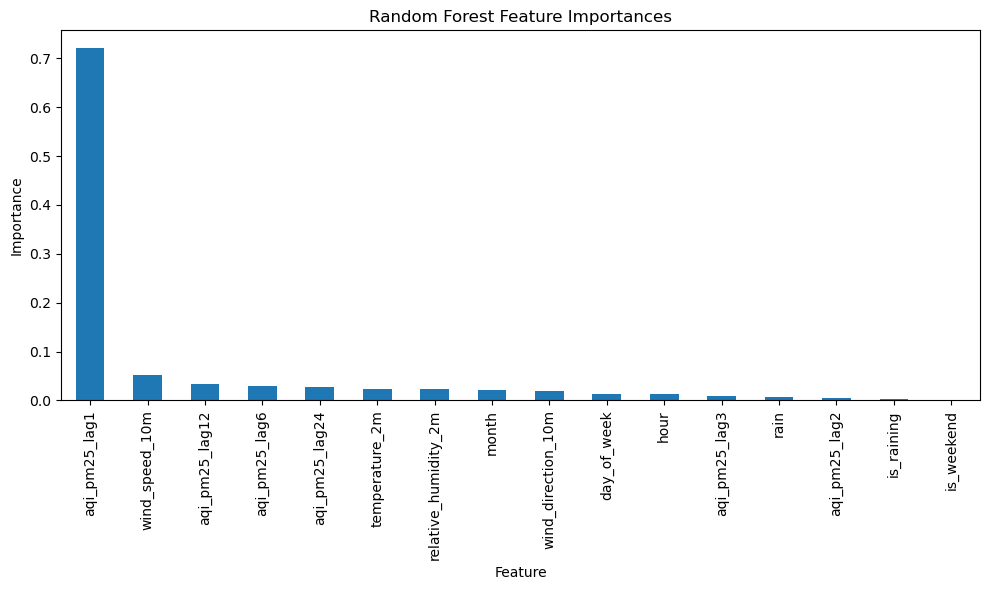

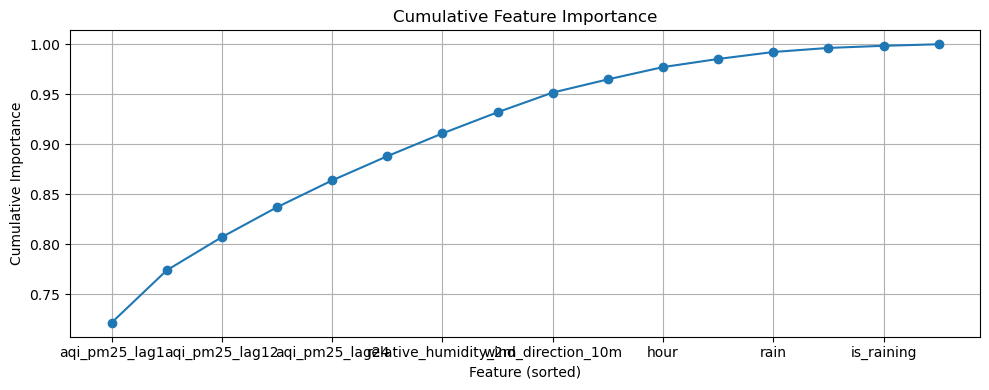

In [14]:
import matplotlib.pyplot as plt

# get feature importances from the trained model
importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

# display
print(fi)

# bar plot of importances
plt.figure(figsize=(10,6))
fi.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# cumulative importance plot
plt.figure(figsize=(10,4))
fi.cumsum().plot(marker='o')
plt.title("Cumulative Feature Importance")
plt.ylabel("Cumulative Importance")
plt.xlabel("Feature (sorted)")
plt.grid(True)
plt.tight_layout()
plt.show()